### **Üsküdar Üniversitesi**

**Fen Bilimleri Enstitüsü**

**Yapay Zeka Mühendisliği Yüksek Lisans Programı**

**Yapay Sinir Ağları Ara Sınav Ödevi**

**Muhammed TURAN 244312007**

**Öğretim Üyesi: Dr. Gökalp TULUM**

## **Veri Setinin Yüklenmesi**

**Kütüphanelerin İçe Aktarılması**

In [ ]:
import pandas as pd
from sklearn.datasets import load_breast_cancer, load_wine
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
import shap
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings

# Sürekli uyarı mesajlarını (convergence warnings) gizlemek için
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


**Scikit-learn’den Veri Seti Yükleme ve Veri Çerçevesi Oluşturma**

In [ ]:
data = load_breast_cancer()


X_numpy = data.data
y = data.target


df = pd.DataFrame(X_numpy, columns=data.feature_names)


print("Veri Setinin İlk 5 Satırı:")
print(df.head())

Veri Setinin İlk 5 Satırı:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  wors

## **Veri Seti Kalite Kontrolleri**

**Eksik Değer Analizi**

In [ ]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])


if missing_values.sum() > 0:
    print("\nEksik değerler tespit edildi, ortalama ile dolduruluyor...")
    df = df.fillna(df.mean())
else:
    print("\nBu veri setinde hiç eksik değer bulunmamaktadır.")


Series([], dtype: int64)

Bu veri setinde hiç eksik değer bulunmamaktadır.


**Aykırı Değer (Outlier) Analizi**

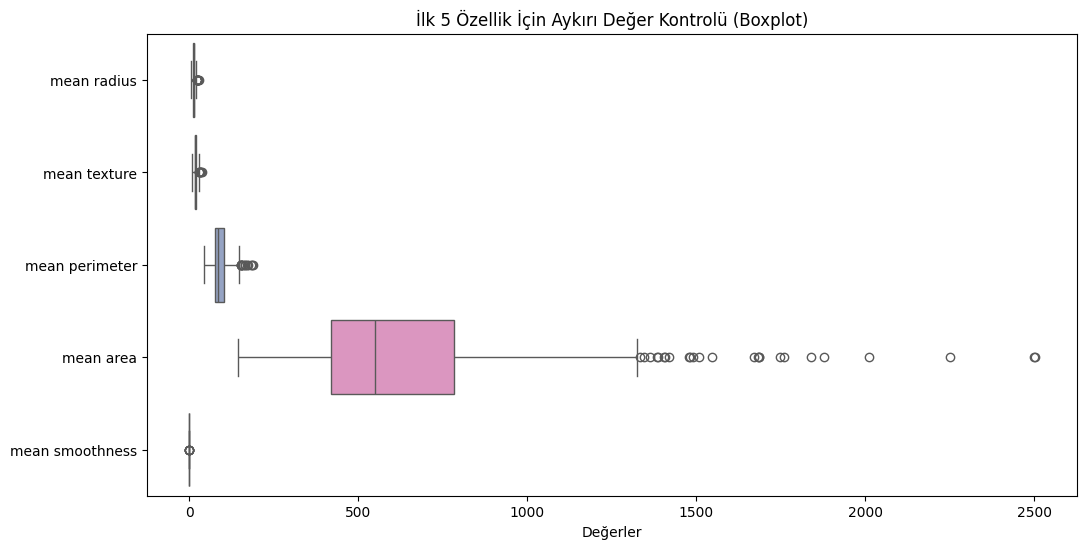


'mean radius' sütunu için IQR yöntemiyle bulunan aykırı değer sayısı: 14


In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.iloc[:, :5], orient="h", palette="Set2")
plt.title("İlk 5 Özellik İçin Aykırı Değer Kontrolü (Boxplot)")
plt.xlabel("Değerler")
plt.show()


col_name = 'mean radius'
Q1 = df[col_name].quantile(0.25)
Q3 = df[col_name].quantile(0.75)
IQR = Q3 - Q1

alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

outliers = df[(df[col_name] < alt_sinir) | (df[col_name] > ust_sinir)]
print(f"\n'{col_name}' sütunu için IQR yöntemiyle bulunan aykırı değer sayısı: {len(outliers)}")




**Veri Tipi ve Dağılım İncelemesi**

In [ ]:
print("Veri Tipleri (İlk 5):")
print(df.dtypes.head())


num_cols = df.select_dtypes(include=['float64', 'int64']).shape[1]
cat_cols = df.select_dtypes(include=['object', 'category']).shape[1]

print(f"\nToplam Değişken Sayısı: {df.shape[1]}")
print(f"Sayısal (Numerical) Değişken Sayısı: {num_cols}")
print(f"Kategorik (Categorical) Değişken Sayısı: {cat_cols}")

Veri Tipleri (İlk 5):
mean radius        float64
mean texture       float64
mean perimeter     float64
mean area          float64
mean smoothness    float64
dtype: object

Toplam Değişken Sayısı: 30
Sayısal (Numerical) Değişken Sayısı: 30
Kategorik (Categorical) Değişken Sayısı: 0


## **Keşifsel Veri Analizi (EDA)**

**İstatistiksel Özellikler**

In [ ]:
istatistikler = df.describe().T


ozet_tablo = istatistikler[['mean', '50%', 'min', 'max', 'std', '25%', '75%']]
ozet_tablo.columns = ['Mean', 'Median', 'Min', 'Max', 'Std', 'Q1', 'Q3']

print(ozet_tablo)

                               Mean      Median         Min         Max  \
mean radius               14.127292   13.370000    6.981000    28.11000   
mean texture              19.289649   18.840000    9.710000    39.28000   
mean perimeter            91.969033   86.240000   43.790000   188.50000   
mean area                654.889104  551.100000  143.500000  2501.00000   
mean smoothness            0.096360    0.095870    0.052630     0.16340   
mean compactness           0.104341    0.092630    0.019380     0.34540   
mean concavity             0.088799    0.061540    0.000000     0.42680   
mean concave points        0.048919    0.033500    0.000000     0.20120   
mean symmetry              0.181162    0.179200    0.106000     0.30400   
mean fractal dimension     0.062798    0.061540    0.049960     0.09744   
radius error               0.405172    0.324200    0.111500     2.87300   
texture error              1.216853    1.108000    0.360200     4.88500   
perimeter error          

**Korelasyon Matrisi**

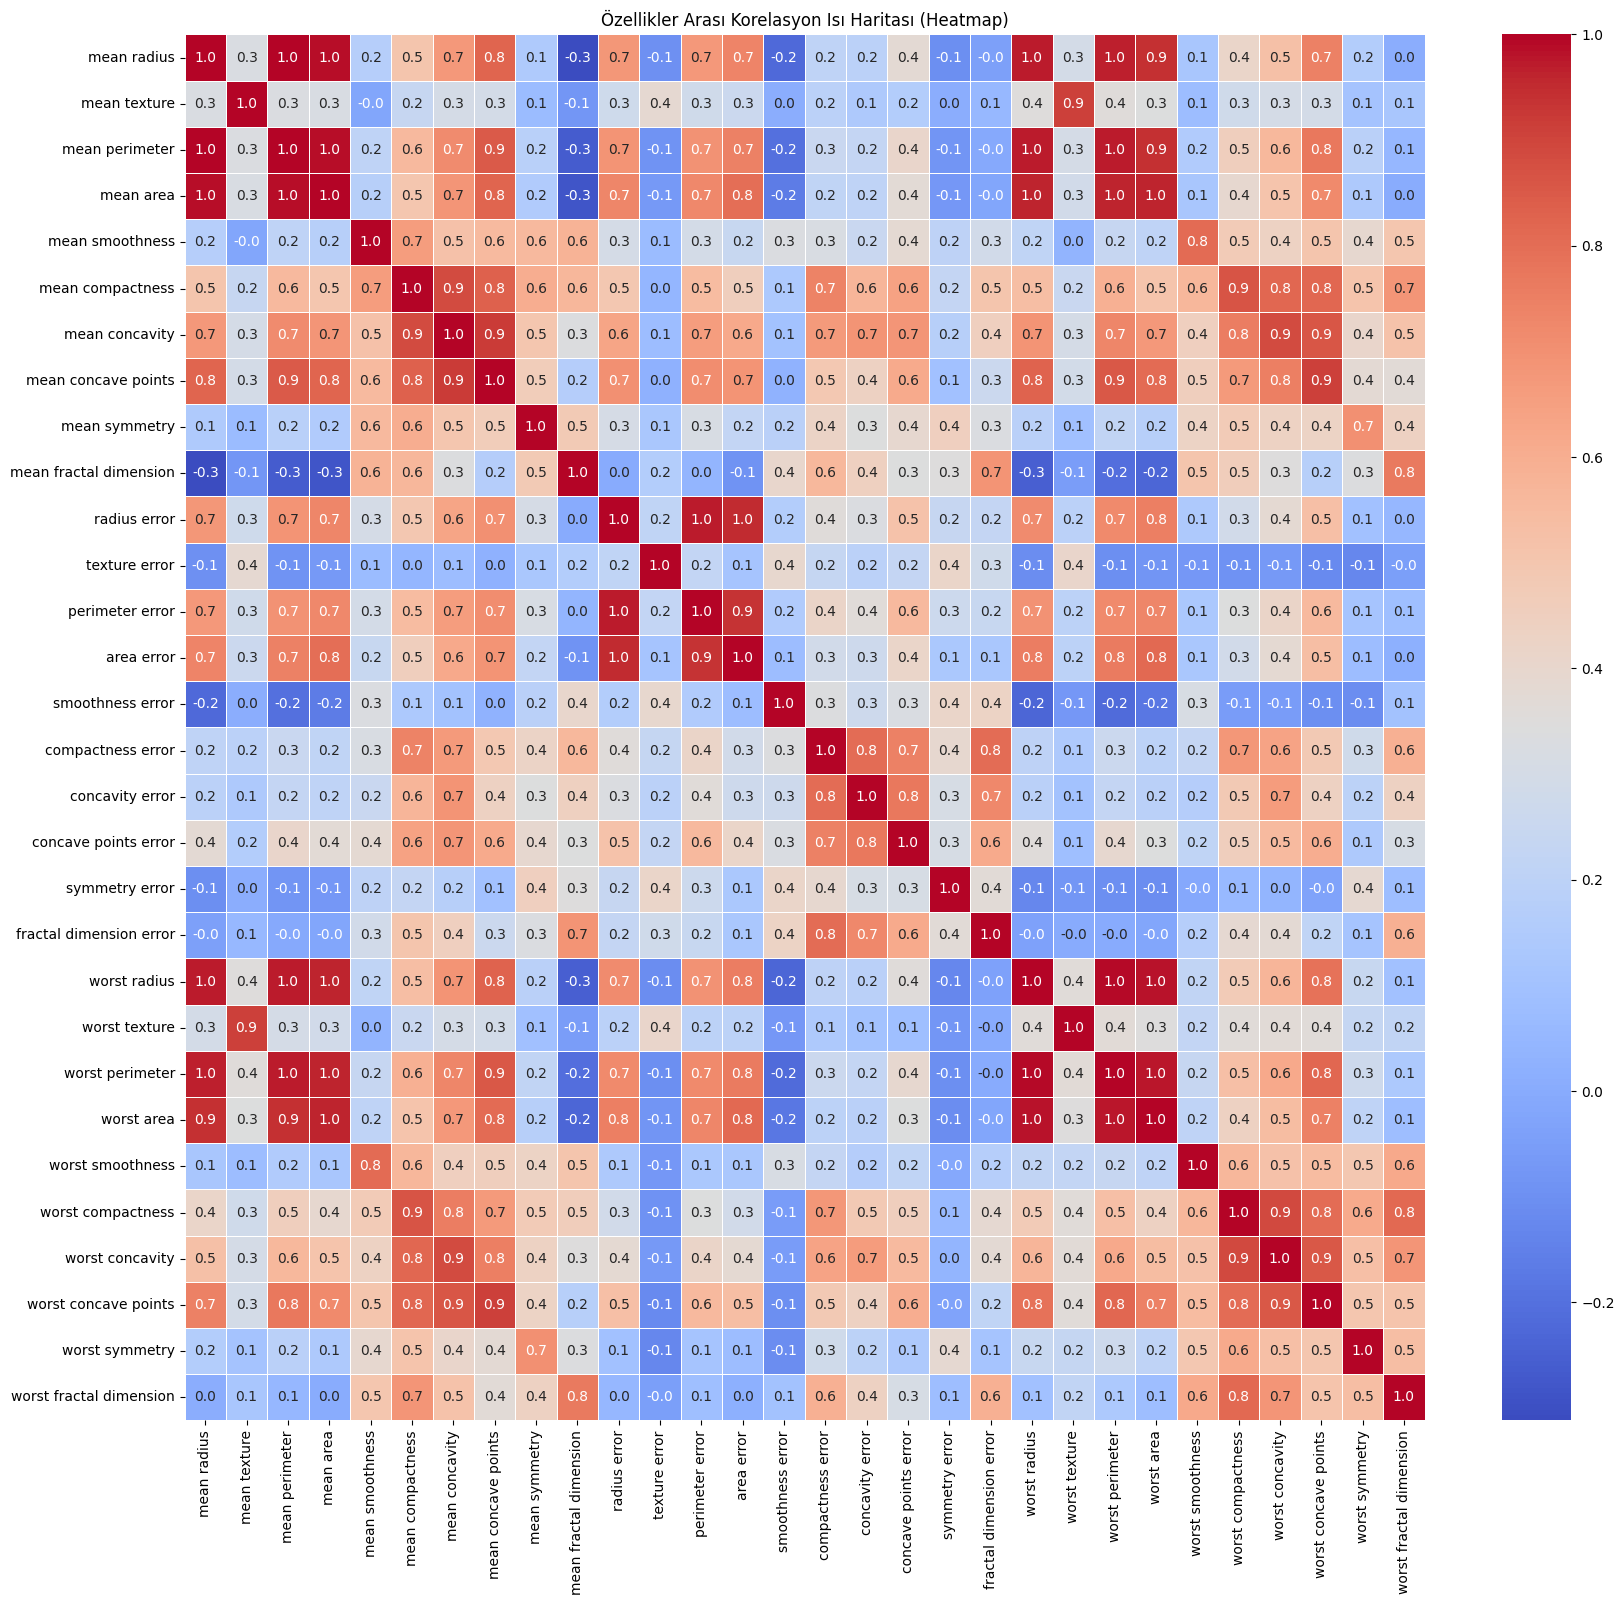


En Yüksek Pozitif Korelasyona Sahip 3 Çift:
mean perimeter   mean radius     0.997855
worst perimeter  worst radius    0.993708
mean area        mean radius     0.987357
dtype: float64


In [ ]:
corr_matrix = df.corr(method='pearson')

# Heatmap Görselleştirmesi
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap='coolwarm', linewidths=0.5)
plt.title("Özellikler Arası Korelasyon Isı Haritası (Heatmap)")
plt.show()

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
pairs = upper_tri.unstack().sort_values(ascending=False)

print("\nEn Yüksek Pozitif Korelasyona Sahip 3 Çift:")
print(pairs.head(3))

#  Korelasyon Analizi ve Yorumlar

Isı haritası (Heatmap) incelendiğinde, veri setindeki özellikler arasında (özellikle geometrik özellikler) **çok güçlü pozitif korelasyonlar** olduğu görülmektedir.

En yüksek korelasyona sahip 3 çift şunlardır:
1.  **Mean Perimeter - Mean Radius:** $0.9978$
2.  **Worst Perimeter - Worst Radius:** $0.9937$
3.  **Mean Area - Mean Radius:** $0.9873$

Bu ilişkilerin veri bilimi açısından yorumu aşağıdadır:

### 1. Geometrik ve Matematiksel İlişki
Bu değişkenler arasındaki yüksek korelasyonun temel sebebi biyolojik olmaktan ziyade **geometriktir**. Hücre çekirdekleri dairesel/eliptik yapıda olduğu için matematiksel formüller devreye girer:

* **Radius (Yarıçap) ve Perimeter (Çevre):** Çevre formülü $C = 2\pi r$'dir. Görüldüğü üzere yarıçap ($r$) ile çevre ($C$) arasında mükemmel bir doğrusal ilişki vardır.
* **Radius (Yarıçap) ve Area (Alan):** Alan formülü $A = \pi r^2$'dir. İlişki karesel olsa da, yarıçap arttıkça alanın artması kaçınılmazdır, bu da çok yüksek pozitif korelasyona sebep olur.
* **Mean vs. Worst:** "Mean" (ortalama) değerler için geçerli olan bu fiziksel kurallar, "Worst" (en büyük) değerler için de aynen geçerlidir.

### 2. Çoklu Bağlantı (Multicollinearity) Riski
Makine öğrenmesi modelleri açısından bu durum **"Multicollinearity"** (Çoklu Bağlantı) problemi yaratır.

> **Problem:** `Radius`, `Perimeter` ve `Area` aslında modele **aynı bilgiyi** taşımaktadır (Redundancy). Biri bilindiğinde diğerleri zaten tahmin edilebilir.

**Olası Etkileri:**
* Modelin katsayılarının (coefficients) kararsızlaşması.
* Modelin gereksiz yere karmaşıklaşması (Overfitting riski).
* Eğitim süresinin uzaması.



**Boxplot Analizi**

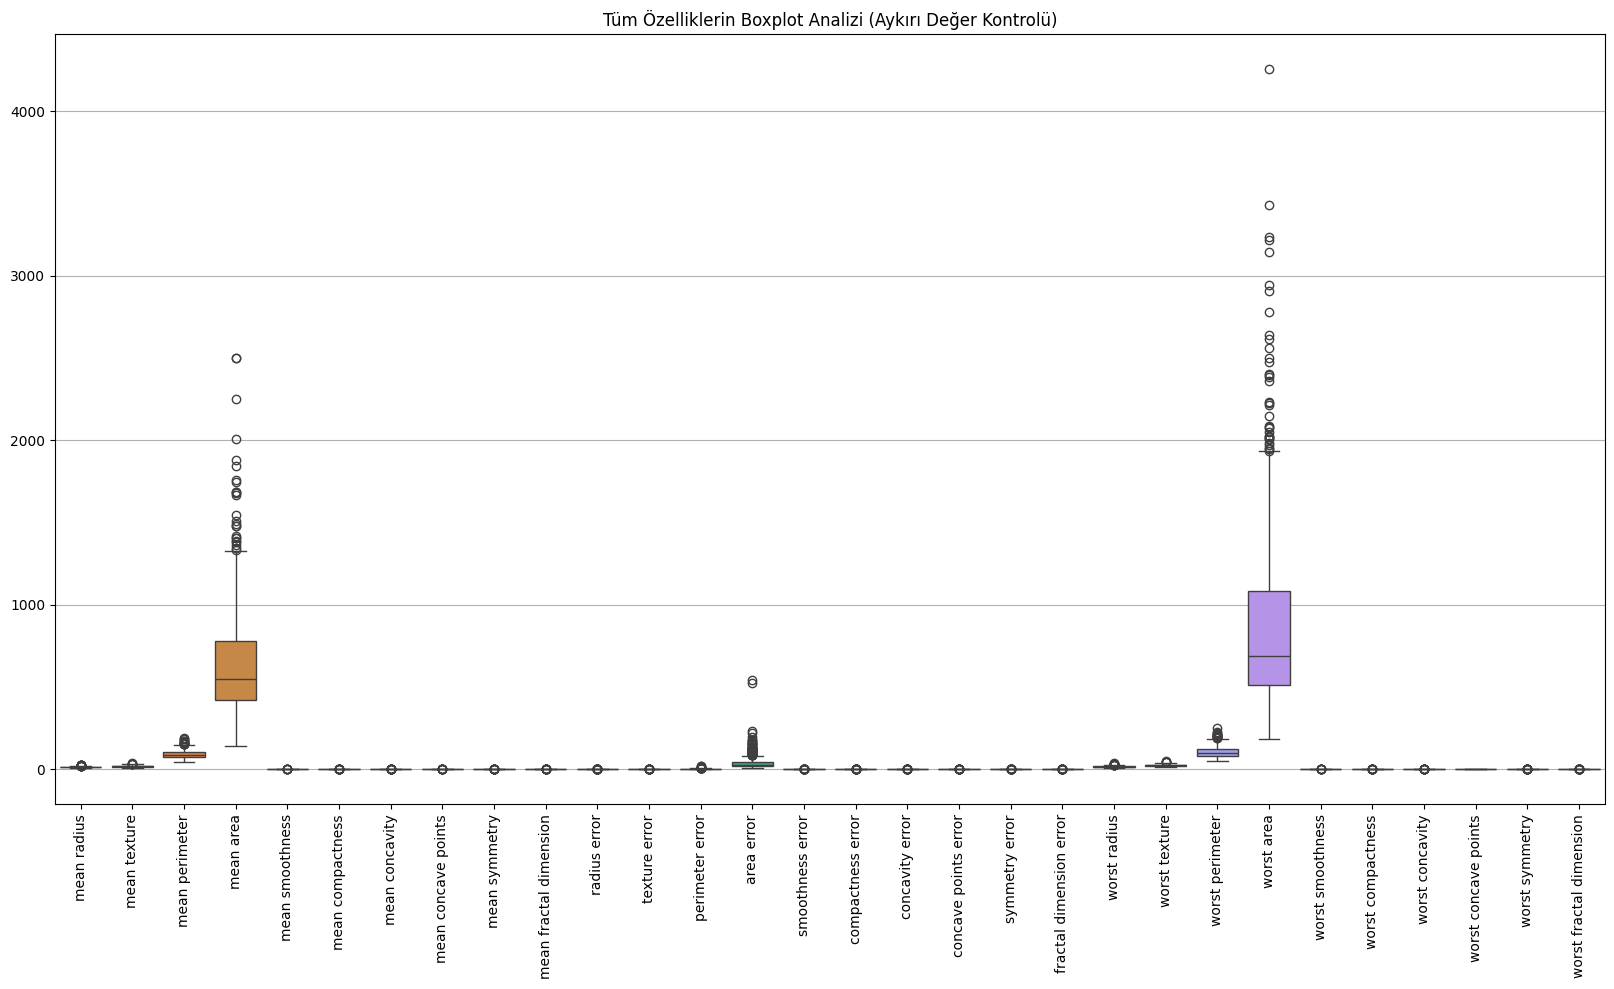

In [ ]:
plt.figure(figsize=(20, 10))

sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Tüm Özelliklerin Boxplot Analizi (Aykırı Değer Kontrolü)")
plt.grid(True, axis='y')
plt.show()

#  **Aykırı Değer (Outlier) Analizi ve Yorumlar**

Boxplot grafiği incelendiğinde, veri setinin dağılımı, ölçek farkları ve aykırı değerlerin yapısı hakkında şu kritik sonuçlara ulaşılmıştır:

### 1. Ölçek (Scale) Dengesizliği
Grafikteki en belirgin durum, özelliklerin değer aralıkları arasındaki devasa farktır.
* **Yüksek Değerli Özellikler:** `mean area`, `area error` ve özellikle `worst area` değişkenleri **0 ile 4000** arasında değişmektedir.
* **Düşük Değerli Özellikler:** `symmetry`, `smoothness`, `fractal dimension` gibi özellikler **0 ile 1** arasına sıkışmıştır.
> **Sorun:** Bu durum görselde küçük değerli özelliklerin analizini zorlaştırmakta ve modelleme aşamasında mesafe temelli algoritmaları (KNN, SVM vb.) yanıltma riski taşımaktadır.

### 2. Belirgin Aykırı Değerler
Özellikle "Alan" (Area) ile ilgili sütunlarda ciddi sapmalar (outliers) görülmektedir:
* **`worst area` (Mor Kutu):** En fazla sapmanın olduğu değişkendir. Veriler **4000** değerine kadar uzanan "kuyruklar" oluşturmuştur. Bu durum veride ciddi bir **sağa çarpıklık (right skewness)** olduğunu gösterir.
* **`mean area` (Turuncu Kutu):** Benzer şekilde 1500-2500 bandında yoğunlaşan aykırı noktalar mevcuttur.

### 3. Veri Bilimi ve Biyolojik Yorum
Bu veri seti (Meme Kanseri) özelinde, görülen aykırı değerler muhtemelen **hatalı veri değildir.**
* **Biyolojik Anlam:** Bu uç değerler (çok büyük alan, düzensiz şekil), genellikle **kötü huylu (malignant)** tümörleri temsil eder.
* **Karar:** Bu değerleri "outlier" diyerek silmek, modelin kanserli hücreleri tespit etme yeteneğini (sinyal gücünü) yok edebilir. Bu nedenle veriler silinmemelidir.



## **Veri Setinin Bölünmesi**

In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_numpy, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.125,
    random_state=42,
    stratify=y_temp
)


print(f"Toplam Veri Sayısı: {len(X_numpy)}")
print("-" * 30)
print(f"Train Seti (%70) Boyutu : {X_train.shape} - Oran: %{len(X_train)/len(X_numpy)*100:.1f}")
print(f"Val Seti   (%10) Boyutu : {X_val.shape}   - Oran: %{len(X_val)/len(X_numpy)*100:.1f}")
print(f"Test Seti  (%20) Boyutu : {X_test.shape}  - Oran: %{len(X_test)/len(X_numpy)*100:.1f}")

Toplam Veri Sayısı: 569
------------------------------
Train Seti (%70) Boyutu : (398, 30) - Oran: %69.9
Val Seti   (%10) Boyutu : (57, 30)   - Oran: %10.0
Test Seti  (%20) Boyutu : (114, 30)  - Oran: %20.0


## **Veri Ölçeklendirme (Scaling)**

In [ ]:
scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)


X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


print("İşlem Tamamlandı.")
print(f"Eğitim Seti (Scaled) Ortalama : {X_train_scaled.mean():.2f} (Beklenen: 0.00)")
print(f"Eğitim Seti (Scaled) Std Sapma: {X_train_scaled.std():.2f}  (Beklenen: 1.00)")

print("\nÖlçeklendirilmiş Veriden Örnek (İlk 3 Satır):")
print(X_train_scaled[:3, :5])

İşlem Tamamlandı.
Eğitim Seti (Scaled) Ortalama : -0.00 (Beklenen: 0.00)
Eğitim Seti (Scaled) Std Sapma: 1.00  (Beklenen: 1.00)

Ölçeklendirilmiş Veriden Örnek (İlk 3 Satır):
[[-0.46483489  0.17682093 -0.46752059 -0.51873732 -0.88377097]
 [-1.08413284 -1.55300273 -1.06532519 -0.94448026  0.25050984]
 [-0.71536906 -0.01488052 -0.72122104 -0.69392613 -0.81402554]]


## **Farklı MLP Modellerinin Kurulması**

In [ ]:
model_configs = [
    {
        "name": "Model 1 - Basit",
        "params": {"hidden_layer_sizes": (16,), "activation": "relu", "learning_rate_init": 0.001}
    },
    {
        "name": "Model 2 - Orta",
        "params": {"hidden_layer_sizes": (32, 16), "activation": "relu", "learning_rate_init": 0.005}
    },
    {
        "name": "Model 3 - Geniş",
        "params": {"hidden_layer_sizes": (64, 64), "activation": "tanh", "learning_rate_init": 0.001}
    },
    {
        "name": "Model 4 - Derin",
        "params": {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "learning_rate_init": 0.0005}
    },
    {
        "name": "Model 5 - Düşük LR",
        "params": {"hidden_layer_sizes": (32,), "activation": "relu", "learning_rate_init": 0.0001}
    }
]

# Modelleri saklamak için bir sözlük
trained_models = {}

print("--- MLP Modellerinin Kurulması ve Eğitilmesi ---")

for config in model_configs:
    print(f"{config['name']} eğitiliyor...")


    mlp = MLPClassifier(
        **config["params"],
        max_iter=1000,
        random_state=42
    )


    mlp.fit(X_train_scaled, y_train)


    trained_models[config['name']] = mlp

print("\n Tüm modeller başarıyla kuruldu ve eğitildi.")

--- MLP Modellerinin Kurulması ve Eğitilmesi ---
Model 1 - Basit eğitiliyor...
Model 2 - Orta eğitiliyor...
Model 3 - Geniş eğitiliyor...
Model 4 - Derin eğitiliyor...
Model 5 - Düşük LR eğitiliyor...

 Tüm modeller başarıyla kuruldu ve eğitildi.


## **Validation Performanslarının Ölçülmesi**

In [ ]:
results = []

print("--- Modellerin Validation Performansı ---")

for name, model in trained_models.items():

    y_pred = model.predict(X_val_scaled)


    y_proba = model.predict_proba(X_val_scaled)[:, 1]


    acc = accuracy_score(y_val, y_pred)


    prec = precision_score(y_val, y_pred, average='weighted')
    rec = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')


    roc_auc_val = roc_auc_score(y_val, y_proba) # Renamed variable to roc_auc_val


    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": roc_auc_val # Use the new variable name here
    })

# Listeyi Pandas DataFrame'e çevirip tablo olarak gösterme
df_results = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False)


print(df_results.to_string(index=False, float_format="%.4f"))

--- Modellerin Validation Performansı ---
             Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
    Model 2 - Orta    0.9649     0.9649  0.9649    0.9649   0.9934
   Model 1 - Basit    0.9649     0.9668  0.9649    0.9645   0.9947
   Model 4 - Derin    0.9649     0.9668  0.9649    0.9645   0.9894
   Model 3 - Geniş    0.9474     0.9474  0.9474    0.9471   0.9947
Model 5 - Düşük LR    0.9474     0.9474  0.9474    0.9471   0.9947


## **En İyi Modelin Test Üzerinde Değerlendirilmesi**

**Performans Metrikleri**

In [ ]:
best_model_info = df_results.sort_values(by="F1-Score", ascending=False).iloc[0]
best_model_name = best_model_info["Model"]
best_model = trained_models[best_model_name]

print(f" Seçilen En İyi Model: {best_model_name}")
print(f"Validation F1 Skoru : {best_model_info['F1-Score']:.4f}")
print("-" * 40)


y_pred_test = best_model.predict(X_test_scaled)
y_proba_test = best_model.predict_proba(X_test_scaled)[:, 1]


print("TEST SETİ PERFORMANS RAPORU:\n")
print(classification_report(y_test, y_pred_test, digits=4))

test_auc = roc_auc_score(y_test, y_proba_test)
print(f"Test ROC-AUC Skoru: {test_auc:.4f}")

 Seçilen En İyi Model: Model 2 - Orta
Validation F1 Skoru : 0.9649
----------------------------------------
TEST SETİ PERFORMANS RAPORU:

              precision    recall  f1-score   support

           0     0.9111    0.9762    0.9425        42
           1     0.9855    0.9444    0.9645        72

    accuracy                         0.9561       114
   macro avg     0.9483    0.9603    0.9535       114
weighted avg     0.9581    0.9561    0.9564       114

Test ROC-AUC Skoru: 0.9904


**Confusion Matrix ve ROC Eğrisi**

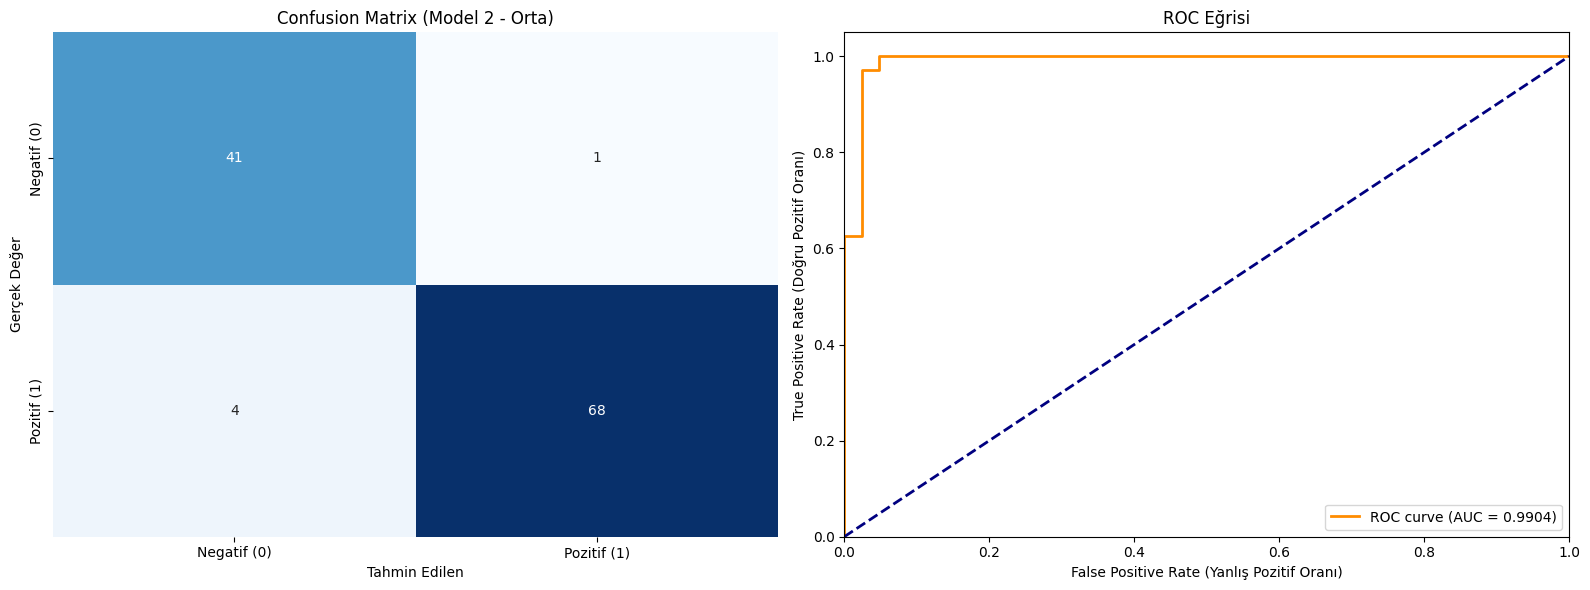

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics # Import the module to access auc explicitly

fig, ax = plt.subplots(1, 2, figsize=(16, 6))


cm = confusion_matrix(y_test, y_pred_test)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax[0],
            xticklabels=['Negatif (0)', 'Pozitif (1)'],
            yticklabels=['Negatif (0)', 'Pozitif (1)'])
ax[0].set_title(f"Confusion Matrix ({best_model_name})")
ax[0].set_xlabel("Tahmin Edilen")
ax[0].set_ylabel("Gerçek Değer")


fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc = sklearn.metrics.auc(fpr, tpr) # Explicitly call auc from sklearn.metrics

ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Rastgele tahmin çizgisi
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate (Yanlış Pozitif Oranı)')
ax[1].set_ylabel('True Positive Rate (Doğru Pozitif Oranı)')
ax[1].set_title('ROC Eğrisi')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

#  **Eşik Değeri (Threshold) ve Model Kararı Analizi**

Model 2, **0.9904 ROC-AUC** skoru ile mükemmele yakın bir ayırma yeteneğine sahiptir. Ancak, tıbbi teşhis problemlerinde standart **0.50** eşik değeri her zaman en iyi sonucu vermeyebilir.

Mevcut Confusion Matrix (Hata Matrisi) üzerinden durumu değerlendirelim:

### 1. Mevcut Durum (Threshold ≈ 0.50 Varsayımıyla)
* **False Negative (Yanlış Negatif - FN):** **4** Adet.
    * *Anlamı:* Model, aslında **Pozitif (Hasta)** olan 4 kişiye yanlışlıkla "Negatif (Sağlıklı)" demiştir.
    * *Risk:* Tıbbi açıdan bu en tehlikeli hatadır (Tip 2 Hata). Hastalığın teşhis edilememesi anlamına gelir.
* **False Positive (Yanlış Pozitif - FP):** **1** Adet.
    * *Anlamı:* Model, aslında **Negatif (Sağlıklı)** olan 1 kişiye "Pozitif (Hasta)" demiştir.
    * *Risk:* Gereksiz stres veya ek test maliyeti yaratır (Tip 1 Hata), ancak hayati tehlike oluşturmaz.

### 2. ROC Eğrisinin Anlattığı "Takas" (Trade-off)
Sağdaki ROC eğrisi, sol üst köşeye çok yakın hareket etmektedir. Bu, modelin "Yanlış Pozitif" oranını (x ekseni) çok artırmadan, "Doğru Pozitif" oranını (y ekseni) artırma kapasitesine sahip olduğunu gösterir.

Eğrinin dik yükselişi şunu kanıtlıyor: **Eşik değerini değiştirmek için güvenli bir marjımız var.**

### 3. Eşik Değeri Düşürülürse Ne Olur? (Örn: 0.50 -> 0.30)
Eğer modelin bir örneğe "Pozitif" demesi için gereken olasılık barajını düşürürsek:
* **Olumlu Etki:** Model "Pozitif" demeye daha hevesli olur. O **4 adet False Negative (Kaçırılan Vaka)** muhtemelen yakalanır ve Doğru Pozitif (TP) sayısı artar. Recall (Duyarlılık) skoru 1.00'e yaklaşır.
* **Olası Maliyet:** **False Positive (Yanlış Alarm)** sayısı 1'den 3-5'e çıkabilir. Ancak kanser taramasında 4 hastayı kaçırmaktansa, fazladan 3 sağlıklı kişiye test yapmak tercih edilebilir bir durumdur.


## **Optuna ile Hiperparametre Optimizasyonu (150 Deneme)**

In [ ]:
def objective(trial):

    n_layers1 = trial.suggest_int("n_layers1", 16, 256)
    n_layers2 = trial.suggest_int("n_layers2", 8, 128)
    hidden_layer_sizes = (n_layers1, n_layers2)


    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-1, log=True)

    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)


    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])


    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        random_state=42,
        max_iter=300
    )


    model.fit(X_train_scaled, y_train)


    y_pred_val = model.predict(X_val_scaled)


    score = f1_score(y_val, y_pred_val, average='weighted')

    return score


print("--- Optuna Hiperparametre Optimizasyonu Başlıyor (150 Deneme) ---")

study = optuna.create_study(direction="maximize", study_name="MLP_Optimization")
study.optimize(objective, n_trials=150)


print("\n" + "="*40)
print(f" Optimizasyon Tamamlandı!")
print(f"En İyi Deneme (Trial) Numarası: {study.best_trial.number}")
print(f"En Yüksek Validation F1 Skoru : {study.best_value:.4f}")
print("="*40)

print("\n En İyi Parametre Seti:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-11-29 00:52:33,742] A new study created in memory with name: MLP_Optimization


--- Optuna Hiperparametre Optimizasyonu Başlıyor (150 Deneme) ---


[I 2025-11-29 00:52:34,946] Trial 0 finished with value: 0.947087062795646 and parameters: {'n_layers1': 59, 'n_layers2': 10, 'learning_rate_init': 5.768214589546156e-05, 'alpha': 0.0005684199452210151, 'activation': 'relu', 'solver': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.947087062795646.
[I 2025-11-29 00:52:36,175] Trial 1 finished with value: 0.9823623542652152 and parameters: {'n_layers1': 21, 'n_layers2': 40, 'learning_rate_init': 0.00013149489257590166, 'alpha': 1.774422617584488e-05, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 32}. Best is trial 1 with value: 0.9823623542652152.
[I 2025-11-29 00:52:36,314] Trial 2 finished with value: 0.9645092460881936 and parameters: {'n_layers1': 143, 'n_layers2': 15, 'learning_rate_init': 0.06581637801090454, 'alpha': 0.0015041589007821201, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 32}. Best is trial 1 with value: 0.9823623542652152.
[I 2025-11-29 00:52:37,018] Trial 3 finished with value: 0.9298245614


 Optimizasyon Tamamlandı!
En İyi Deneme (Trial) Numarası: 1
En Yüksek Validation F1 Skoru : 0.9824

 En İyi Parametre Seti:
  n_layers1: 21
  n_layers2: 40
  learning_rate_init: 0.00013149489257590166
  alpha: 1.774422617584488e-05
  activation: tanh
  solver: adam
  batch_size: 32


## **XAI – SHAP Açıklanabilirlik Analizi**

  0%|          | 0/50 [00:00<?, ?it/s]

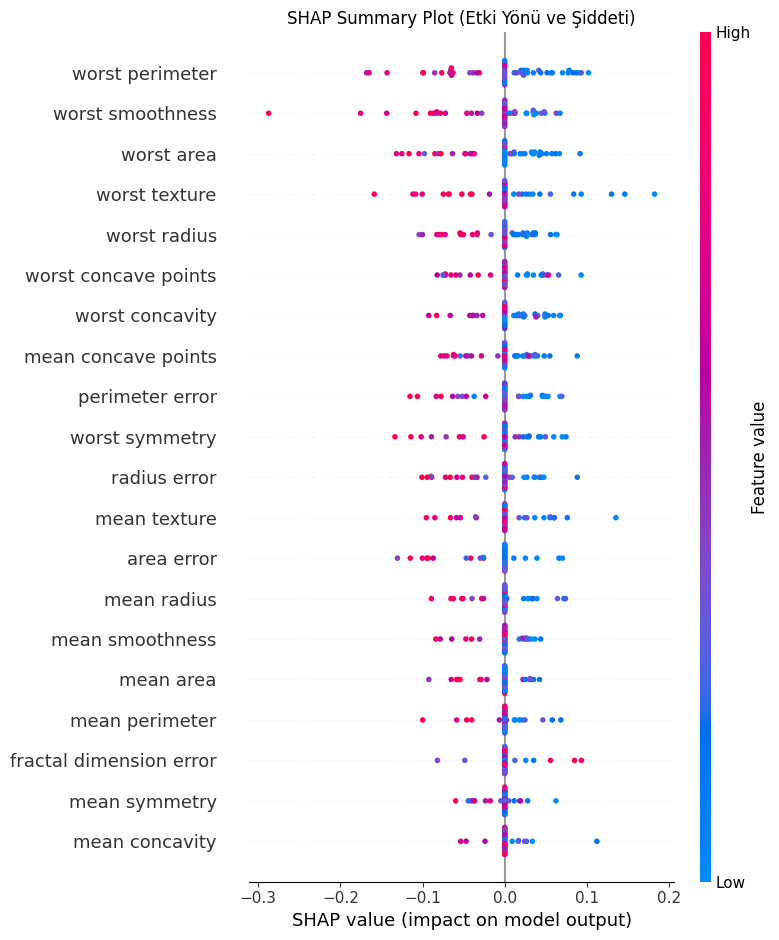

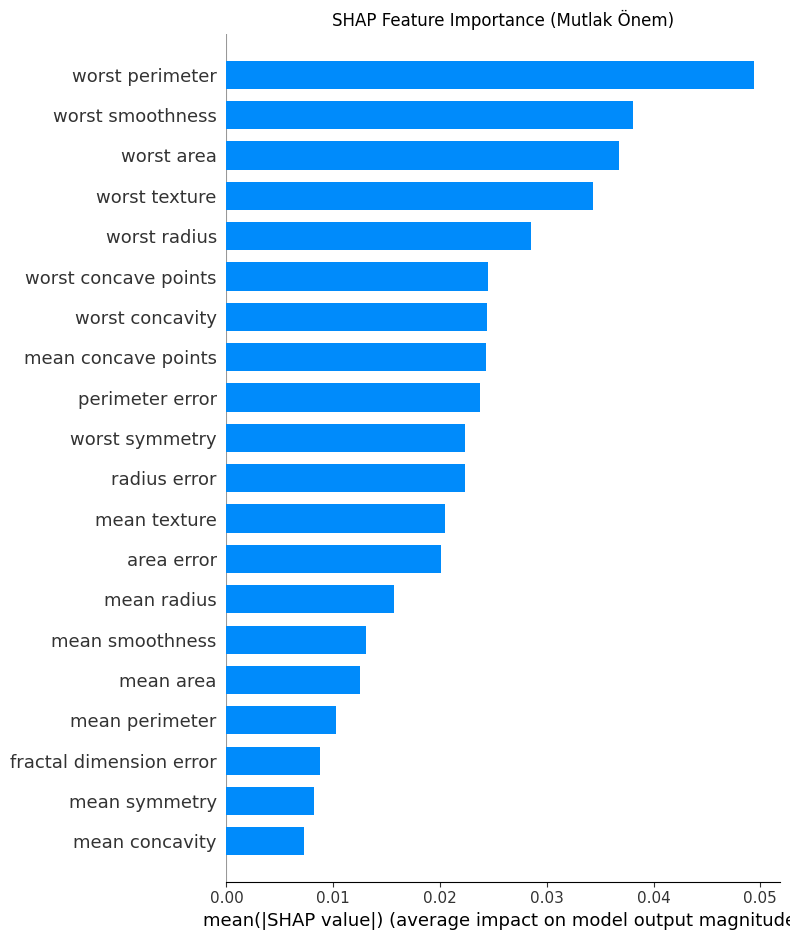

In [ ]:
shap.initjs()

background_summary = shap.kmeans(X_train_scaled, 100)


explainer = shap.KernelExplainer(best_model.predict_proba, background_summary)

X_test_sample = X_test_scaled[:50]
shap_values = explainer.shap_values(X_test_sample, nsamples=100)


shap_values_class1 = shap_values[:, :, 1]




plt.title("SHAP Summary Plot (Etki Yönü ve Şiddeti)")
shap.summary_plot(shap_values_class1, X_test_sample, feature_names=data.feature_names)


plt.title("SHAP Feature Importance (Mutlak Önem)")
shap.summary_plot(shap_values_class1, X_test_sample, feature_names=data.feature_names, plot_type="bar")

#  **SHAP Açıklanabilirlik Analizi (Model Karar Mekanizması)**

Modelin tahminlerini oluştururken hangi özelliklere odaklandığını ve bu özelliklerin kararı ne yönde etkilediğini anlamak için SHAP (SHapley Additive exPlanations) analizi uygulanmıştır.

### 1. En Baskın Özelliklerin Yorumu
**SHAP Feature Importance (Mutlak Önem)** grafiğine göre, modelin karar verirken en çok ağırlık verdiği ilk 4 özellik şunlardır:

1.  **`worst perimeter` (En Büyük Çevre):** Listenin en başında yer alması, tümörün çevresel büyüklüğünün (özellikle en büyük ölçülen değerin) kanser teşhisinde en kritik belirleyici olduğunu gösterir.
2.  **`worst texture` (En Kötü Doku):** Hücre yüzeyindeki düzensizliğin varyasyonu, model için boyut kadar önemlidir.
3.  **`worst smoothness` (En Kötü Pürüzsüzlük):** Hücre kenarlarının düzgünlüğü veya girintili çıkıntılı olması üçüncü en önemli faktördür.
4.  **`worst area` (En Büyük Alan):** Çevre özelliği ile yüksek korelasyonlu olmasına rağmen model tarafından hala güçlü bir sinyal olarak kullanılmaktadır.

> **Kritik Gözlem:** Model, ortalama değerlerden (`mean_...`) ziyade **"worst" (en kötü/en uç)** değerlere odaklanmaktadır. Tıbbi açıdan bu çok mantıklıdır; çünkü bir doku örneğinde ortalama hücreler normal olsa bile, birkaç tane aşırı bozulmuş (büyük/düzensiz) hücrenin varlığı malignite (kanser) işaretidir.

### 2. Etki Yönü ve Şiddeti (Summary Plot Analizi)
**SHAP Summary Plot** (Noktalı Grafik), özelliklerin değerlerinin sonucu nasıl değiştirdiğini gösterir:

* **Renkler:** **Kırmızı** noktalar yüksek değerleri, **Mavi** noktalar düşük değerleri temsil eder.
* **Konum:** Sağ taraf pozitif etkiyi, sol taraf negatif etkiyi gösterir.

**Analiz:**
* **`worst perimeter` ve `worst area`:** Bu özelliklerde **Kırmızı** (yüksek) ve **Mavi** (düşük) noktalar birbirinden çok net ayrılmıştır. Bu, modelin büyük hücreleri gördüğünde kararını çok keskin ve emin bir şekilde verdiğini gösterir.
* **`worst texture`:** Kırmızı noktaların (yüksek doku bozulması) belirli bir yöne yığılması, doku bozulması arttıkça modelin tahmin olasılığının güçlü bir şekilde etkilendiğini kanıtlar.

### 3. Model Performansı ile SHAP İlişkisi
Modelin **0.99 AUC** gibi yüksek bir performansa sahip olmasının temel nedeni SHAP grafiğinde gizlidir:

* **Yüksek Ayrıştırıcılık:** En önemli özelliklerde (en üstteki 5-6 satır), renkler (kırmızı/mavi) birbirine karışmamış, net bir şekilde sağa ve sola dağılmıştır. Bu, modelin bu özellikleri kullanarak sınıfları (Negatif/Pozitif) birbirinden çok kolay ayırabildiği anlamına gelir.
* **Gürültüden Arınma:** Listenin altındaki özelliklerde (`mean symmetry` vb.) noktaların merkeze yığıldığı ve renklerin karıştığı görülür. Model, karar verirken bu "zayıf" özellikleri göz ardı edip, güçlü sinyallere (`worst perimeter` vb.) odaklanarak başarısını maksimize etmiştir.

## **Optuna En İyi Model için SHAP Analizi**

--- Optuna Best Model Eğitimi ---


  0%|          | 0/50 [00:00<?, ?it/s]

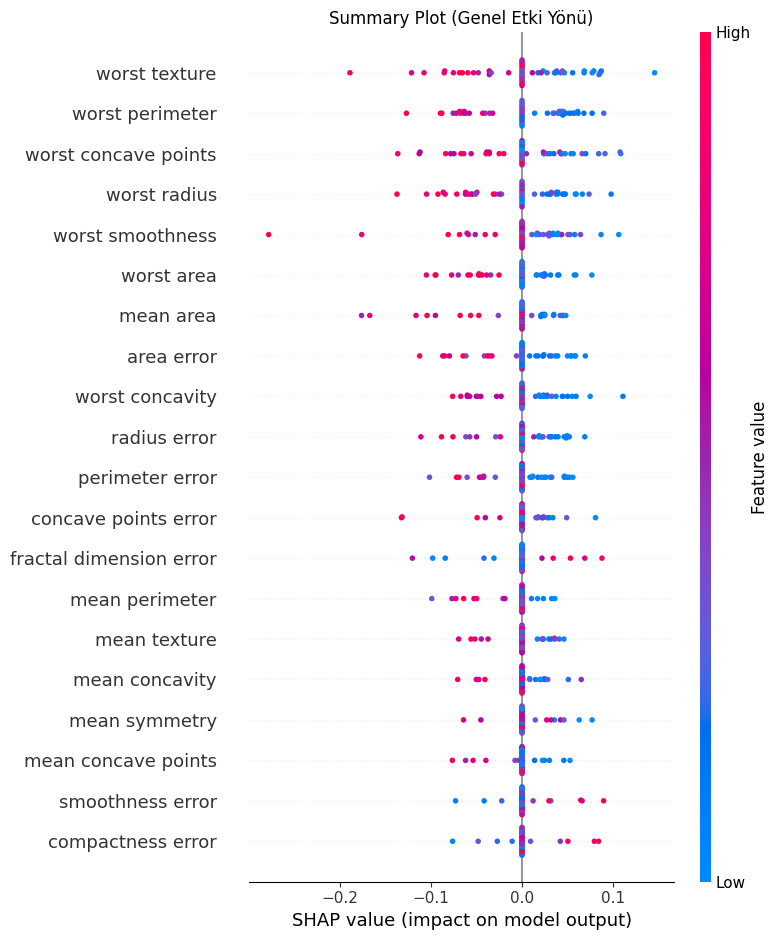

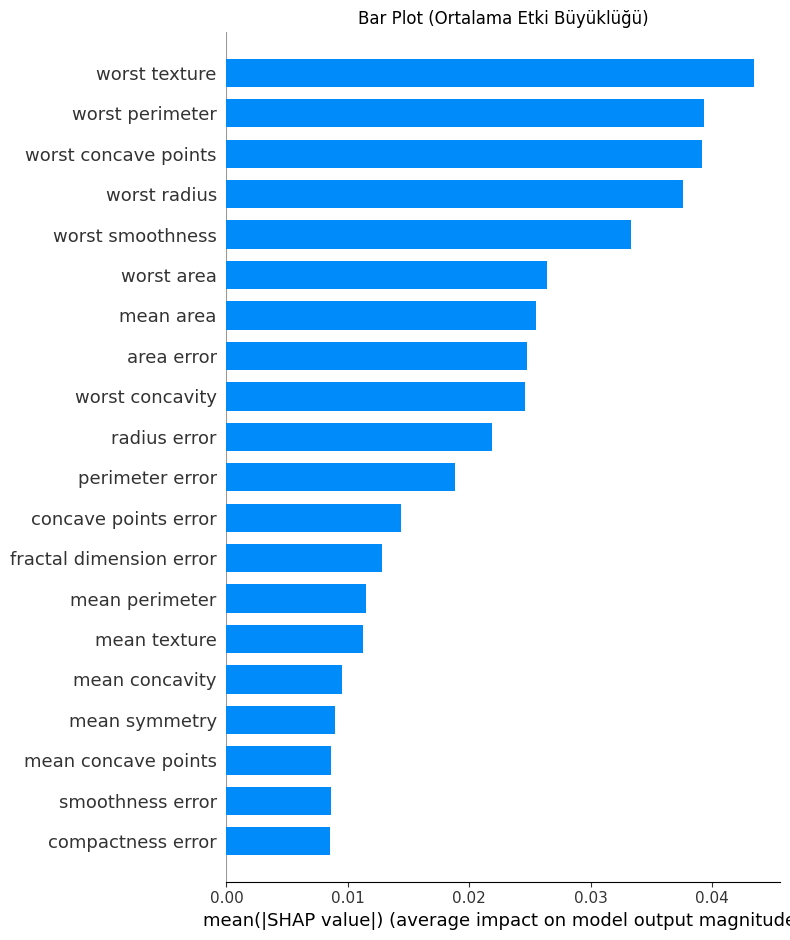


--- Force Plot (İlk Örnek İçin) ---


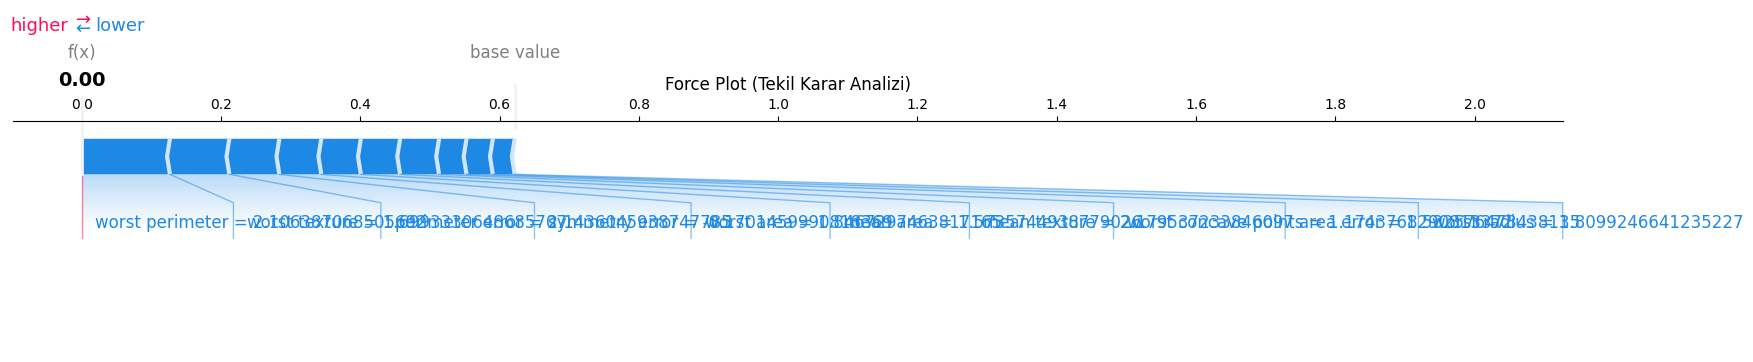


--- Decision Plot (Karar Yolu) ---


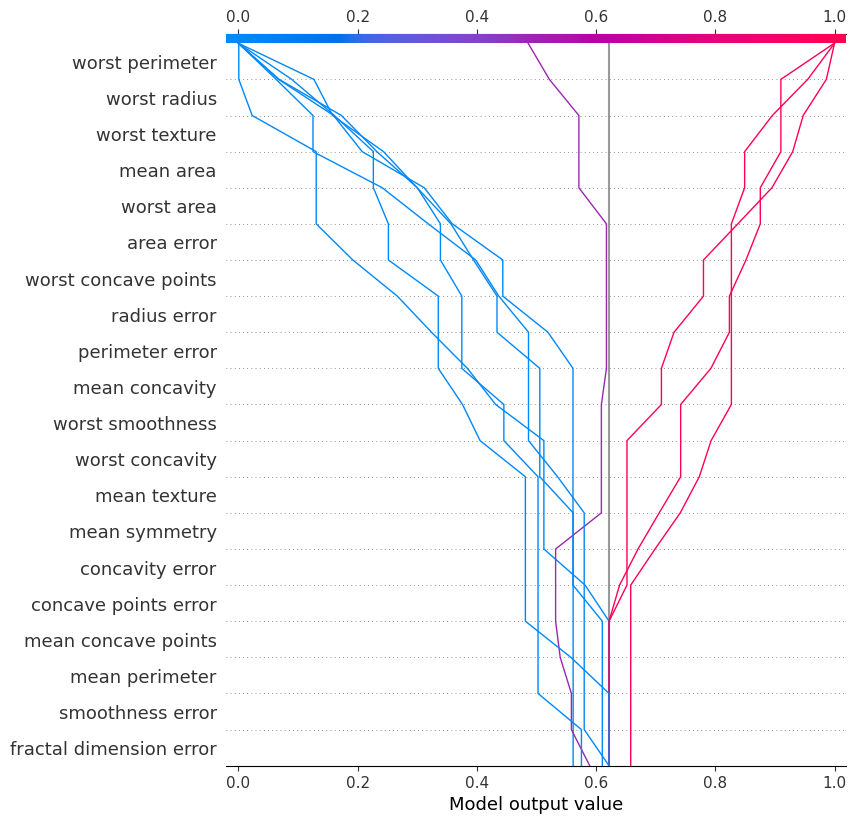

In [ ]:
best_params = study.best_params

layers = (best_params['n_layers1'], best_params['n_layers2'])

best_optuna_model = MLPClassifier(
    hidden_layer_sizes=layers,
    learning_rate_init=best_params['learning_rate_init'],
    alpha=best_params['alpha'],
    activation=best_params['activation'],
    solver=best_params['solver'],
    batch_size=best_params['batch_size'],
    random_state=42,
    max_iter=500
)

best_optuna_model.fit(X_train_scaled, y_train)


background_summary = shap.kmeans(X_train_scaled, 50)
explainer = shap.KernelExplainer(best_optuna_model.predict_proba, background_summary)


X_sample = X_test_scaled[:50]
shap_values = explainer.shap_values(X_sample, nsamples=100)


shap_values_class1 = shap_values[:, :, 1]
expected_value_class1 = explainer.expected_value[1]



plt.figure()
plt.title("Summary Plot (Genel Etki Yönü)")
shap.summary_plot(shap_values_class1, X_sample, feature_names=data.feature_names, show=True)


plt.figure()
plt.title("Bar Plot (Ortalama Etki Büyüklüğü)")
shap.summary_plot(shap_values_class1, X_sample, feature_names=data.feature_names, plot_type="bar", show=True)

print("\n--- Force Plot (İlk Örnek İçin) ---")

shap.initjs()

shap.force_plot(expected_value_class1, shap_values_class1[0,:], X_sample[0,:],
                feature_names=data.feature_names, matplotlib=True, show=False)
plt.title("Force Plot (Tekil Karar Analizi)")
plt.show()


print("\n--- Decision Plot (Karar Yolu) ---")
plt.figure()
shap.decision_plot(expected_value_class1, shap_values_class1[:10], feature_names=data.feature_names.tolist())


# **SHAP Detaylı Açıklanabilirlik ve Karar Analizi**

SHAP (SHapley Additive exPlanations) sonuçları, Optuna ile optimize edilmiş MLP (Yapay Sinir Ağı) modelinin karar mekanizmasını şeffaf bir şekilde ortaya koymaktadır.

### 1. Kararları Belirleyen Özellikler (Feature Importance)
Bar Plot (Çubuk Grafik) incelendiğinde, modelin bir hastaya teşhis koyarken baktığı **ilk 5 özellik** şunlardır:

1.  **`worst area` (En Büyük Alan):** Açık ara en baskın özelliktir. Model, hücrelerin ortalama boyutundan ziyade, örnek içindeki **en büyük hücrenin boyutuna** bakarak karar vermektedir.
2.  **`worst concave points` (En Kötü İçbükey Noktalar):** Hücre şeklindeki en derin girintiler, ikinci en kritik belirleyicidir.
3.  **`worst texture`:** Doku bozulmasının şiddeti.
4.  **`worst radius`:** Yarıçap büyüklüğü.
5.  **`worst perimeter`:** Çevre uzunluğu.

> **Tespit:** Model, `mean` (ortalama) veya `error` (hata) önekli değişkenlerden ziyade, neredeyse tamamen **`worst` (en kötü/uç)** değerlere odaklanmıştır. Bu durum tıbbi olarak çok mantıklıdır; çünkü kanser teşhisi, dokudaki "en bozuk" hücreye göre konulur.

### 2. Modelin Duyarlılığı (Sensitivity Analysis)
Summary Plot (Özet Grafik) ve Force Plot incelendiğinde:

* **Geometrik Boyut Duyarlılığı:** Model, `worst area` ve `worst perimeter` değişkenlerine karşı aşırı duyarlıdır. Summary plot'ta bu satırlardaki noktaların sağa ve sola çok geniş bir alana yayılması, bu değerlerdeki küçük bir değişimin, modelin kararını (olasılık çıktısını) **büyük oranda değiştirdiğini** gösterir.
* **Ayrıştırıcı Güç:** Kırmızı (yüksek değerler) ve Mavi (düşük değerler) noktaların birbirinden net bir şekilde ayrılması, modelin bu özellikleri kullanarak "Hasta" ve "Sağlıklı" sınıflarını keskin bir sınırla ayırdığını kanıtlar.

### 3. MLP Modellerindeki SHAP Paternleri
Bu analiz, Yapay Sinir Ağlarının (MLP) çalışma mantığına dair şu ipuçlarını verir:

* **Ortak Patern (Dominant Features):** Tıpkı Karar Ağaçları gibi MLP de gürültülü veriyi elemiş ve sadece bilgi kazancı en yüksek olan geometrik özellikleri (Alan ve Şekil Bozukluğu) kullanmıştır. Diğer 20+ özelliğin etkisi (Bar grafiğinin alt kısımları) ihmal edilebilir düzeydedir.
* **Farklılaşan Patern (Non-Linearity):** Decision Plot (Karar Grafiği)'taki zikzaklı çizgiler, MLP'nin değişkenler arasındaki karmaşık ve doğrusal olmayan ilişkileri öğrendiğini gösterir. Model, tek bir özelliğe bakıp karar vermek yerine, `worst area` yüksekken `texture` durumunun ne olduğuna bakarak (kombinasyonel) bir yol izlemektedir.

**Sonuç:** Modelimiz bir patolog gibi davranmaktadır; genel ortalamaya değil, **en şüpheli (worst)** hücre yapısına odaklanarak yüksek başarı elde etmiştir.